<a href="https://colab.research.google.com/github/thienan99dt/sentiment140/blob/master/ex_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/content/drive')


Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import re
import pandas as pd
import numpy as np

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from gensim.models import Word2Vec,KeyedVectors

from tensorflow.keras.layers import Embedding

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

PATH = '/content/drive/My Drive/hybrid'
PATH_DATASET = PATH + '/dataset'
PATH_PRETRAIN = PATH + '/pretrained'
PATH

'/content/drive/My Drive/hybrid'

In [4]:
df = pd.read_csv(PATH_DATASET + '/clean_tweet.csv', index_col = 0)
df.dropna(inplace = True)
df.reset_index(drop=True,inplace=True)
X = df[df.columns[1]]
y = df[df.columns[0]]

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.15, random_state = 42)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(X_train.values)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size = 0.1, random_state = 42)

In [8]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

528150


In [9]:
f = open(PATH_PRETRAIN+'/glove.6B.300d.txt')
embeddings_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
#converting text into integer sequences
x_tr_seq1  = tokenizer.texts_to_sequences(X_train) 
x_val_seq1 = tokenizer.texts_to_sequences(X_val)
x_test_seq1 = tokenizer.texts_to_sequences(X_test)

In [12]:
MAX_SEQUENCE_LENGTH = int(0.5*( len(max(x_tr_seq1,key=len)) + len(max(x_val_seq1,key=len)) ))
print(MAX_SEQUENCE_LENGTH)

49


In [0]:
#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
x_val_seq = pad_sequences(x_val_seq1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
x_test_seq = pad_sequences(x_test_seq1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

In [14]:
#create an embedding matrix
EMBEDDING_DIM = 300
hits, misses = 0,0
embedding_matrix = np.zeros((size_of_vocabulary, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits +=1
    else:
        misses+=1
print("Converted %d words (%d misses) : ratio %f" % (hits, misses, (hits/misses)*100))

Converted 96716 words (431433 misses) : ratio 22.417386


In [15]:
embedding_matrix.shape

(528150, 300)

In [22]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
embedding_layer = Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)(inputs)# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedding_layer)
x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(32, activation="relu")(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate=1e-3),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         158445000 
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         186880    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 158,734,857
Trainable params: 289,857
Non-trainable params: 158,445,000
_______________________________________

In [24]:
history = model.fit(x_tr_seq,y_train,batch_size=2048,class_weight = class_weights, epochs=5, validation_data=(x_val_seq, y_val),verbose=1)

Epoch 1/5
598/598 [==============================] - 58s 97ms/step - loss: 0.4315 - accuracy: 0.7986 - val_loss: 0.4192 - val_accuracy: 0.8068
Epoch 2/5
598/598 [==============================] - 57s 95ms/step - loss: 0.4072 - accuracy: 0.8132 - val_loss: 0.4062 - val_accuracy: 0.8130
Epoch 3/5
598/598 [==============================] - 57s 95ms/step - loss: 0.3927 - accuracy: 0.8210 - val_loss: 0.3944 - val_accuracy: 0.8198
Epoch 4/5
598/598 [==============================] - 57s 95ms/step - loss: 0.3828 - accuracy: 0.8267 - val_loss: 0.3900 - val_accuracy: 0.8229
Epoch 5/5
598/598 [==============================] - 57s 95ms/step - loss: 0.3746 - accuracy: 0.8311 - val_loss: 0.3854 - val_accuracy: 0.8253


In [25]:
y_prob = model.predict(x_val_seq)
y_val_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_val, y_val_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.8278    0.8223    0.8250     68142
           1     0.8227    0.8283    0.8255     67858

    accuracy                         0.8253    136000
   macro avg     0.8253    0.8253    0.8253    136000
weighted avg     0.8253    0.8253    0.8253    136000



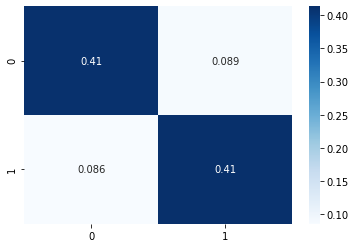

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues')

Sigmoid Function
              precision    recall  f1-score   support

           0     0.8210    0.8293    0.8251    119825
           1     0.8280    0.8197    0.8239    120175

    accuracy                         0.8245    240000
   macro avg     0.8245    0.8245    0.8245    240000
weighted avg     0.8245    0.8245    0.8245    240000



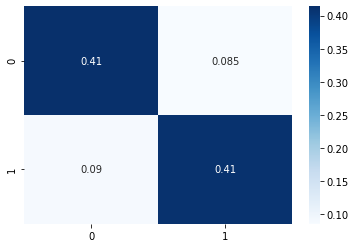

In [30]:
print("Sigmoid Function")
y_prob = model.predict(x_test_seq)
y_test_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_test, y_test_pred, digits = 4))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues')